<a href="https://colab.research.google.com/github/r-kovalch/acter-ner/blob/main/notebooks/acter-cvalue-rerank-annotation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/r-kovalch/acter-ner

fatal: destination path 'acter-ner' already exists and is not an empty directory.


In [ ]:
!git clone https://github.com/lang-uk/extractomat.git

fatal: destination path 'extractomat' already exists and is not an empty directory.


In [ ]:
!git clone https://github.com/AylaRT/ACTER

fatal: destination path 'ACTER' already exists and is not an empty directory.


In [ ]:
!pip install -q \
  numpy==1.26.4 \
  spacy \
  spacy-layout \
  sentence-transformers \
  gitpython \
  matplotlib \
  tqdm -q

!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 119.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
!ls

ACTER			acter-ner	sample_data
acter_en_gt.csv		dummy_test.tsv	train_full.tsv
acter_en_unlabeled.txt	extractomat	val_full.tsv


In [ ]:
import subprocess, sys
from pathlib import Path

# IOB directories inside the cloned ACTER repository
io_dirs = [
    "/content/ACTER/en/corp/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/",
    "/content/ACTER/en/equi/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/",
    "/content/ACTER/en/htfl/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/",
    "/content/ACTER/en/wind/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/",
]

# Output files (80 % train, 20 % validation, no test set)
train_tsv = Path("train_full.tsv")
val_tsv   = Path("val_full.tsv")     # ← our gold set
# dummy test file because the script requires one
test_tsv  = Path("dummy_test.tsv")

args = [
    "python", "/content/acter-ner/term_extractor/preprocess_acter.py",
    "--input_dirs", *io_dirs,
    "--train_output", str(train_tsv),
    "--test_output",  str(test_tsv),
    "--val_output",   str(val_tsv),
    "--test_size", "0.0",            # no test set – everything goes to val
    "--val_size",  "0.2",            # 20 % of data kept with labels
    "--seed",      "42",
]

print("⏳ Running:", " ".join(args))
subprocess.check_call(args)
print("✓ Splits ready →", train_tsv, "and", val_tsv)


⏳ Running: python /content/acter-ner/term_extractor/preprocess_acter.py --input_dirs /content/ACTER/en/corp/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/ /content/ACTER/en/equi/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/ /content/ACTER/en/htfl/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/ /content/ACTER/en/wind/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/ --train_output train_full.tsv --test_output dummy_test.tsv --val_output val_full.tsv --test_size 0.0 --val_size 0.2 --seed 42
✓ Splits ready → train_full.tsv and val_full.tsv


In [ ]:
UNLABELED_TXT = Path("acter_en_unlabeled.txt")      # 80 % raw text
with UNLABELED_TXT.open("w", encoding="utf-8") as out_txt:
    sentence = []
    for line in train_tsv.read_text(encoding="utf-8").splitlines():
        if not line.strip():                   # sentence boundary
            if sentence:
                out_txt.write(" ".join(sentence) + "\n")
                sentence = []
            continue
        token, *_ = line.split("\t")
        sentence.append(token)
    if sentence:                               # trailing sentence
        out_txt.write(" ".join(sentence) + "\n")
print(f"✓ Unlabeled corpus written → {UNLABELED_TXT} ({UNLABELED_TXT.stat().st_size/1e6:.1f} MB)")

✓ Unlabeled corpus written → acter_en_unlabeled.txt (1.0 MB)


In [ ]:
# Cell 4b – rebuild gold-term list by grouping B/I spans from val_full.tsv

from pathlib import Path
import csv

VAL_TSV = Path("val_full.tsv")
GT_CSV  = Path("acter_en_gt.csv")

terms = set()
current = []

for line in VAL_TSV.read_text(encoding="utf-8").splitlines():
    if not line.strip():
        # sentence break → flush any ongoing term
        if current:
            terms.add(" ".join(current).lower())
            current = []
        continue

    token, label = line.split("\t")
    # labels are like "B-TERM", "I-TERM", or "O"
    if label.startswith("B"):
        # start a new term (flush old one first)
        if current:
            terms.add(" ".join(current).lower())
        current = [token]
    elif label.startswith("I") and current:
        # continuation of the current term
        current.append(token)
    else:
        # outside a term → flush
        if current:
            terms.add(" ".join(current).lower())
            current = []

# catch any trailing term
if current:
    terms.add(" ".join(current).lower())

# write out CSV: one term per line
with GT_CSV.open("w", encoding="utf-8", newline="") as f:
    writer = csv.writer(f)
    for t in sorted(terms):
        writer.writerow([t])

print(f"✓ Rebuilt gold CSV with {len(terms):,} unique terms → {GT_CSV}")


✓ Rebuilt gold CSV with 2,235 unique terms → acter_en_gt.csv


In [ ]:
sys.path.insert(0, str(Path.cwd() / "extractomat"))

from pathlib import Path
import spacy
from matcha import cvalue
from tester import TermEvaluator


GT_CSV        = Path("acter_en_gt.csv")             # 20 % gold terms

# 1️⃣ Linguistic pre-processing (tokenise, lemmatise) – any spaCy EN model works
nlp = spacy.load("en_core_web_sm", disable=["ner"])
doc = nlp(UNLABELED_TXT.read_text().lower())

#  2️⃣ C-Value scoring (nested n-grams 2…8 tokens, with slight smoothing)
term_scores, term_occ = cvalue(
    doc,
    n_min=2,     # smallest n-gram to consider
    n_max=8,     # longest n-gram
    smoothing=0.1
)

print(f"Extracted {len(term_scores):,} candidate terms")

Extracted 24,748 candidate terms


In [ ]:
# Cell 5b – robust threshold sweep for C-Value
import numpy as np
from tester import TermEvaluator

# 1) Instantiate the evaluator once:
evaluator = TermEvaluator(
    "acter_en_gt.csv",    # your 20% GT-term list from Step 4
    term_scores,          # from Cell 5
    term_occ,             # from Cell 5
    method="cvalue",
    language="en"
)

# 2) Build 100 thresholds from just below min(score) up to max(score):
scores = np.array(list(term_scores.values()))
t_min, t_max = scores.min(), scores.max()
thresholds = np.linspace(t_min - 1e-9, t_max, num=100)

best = {"f1": -1.0}

# 3) Sweep, catching any zero-division cases:
for t in thresholds:
    try:
        p, r, f1 = evaluator.calculate_metrics(t)
    except ZeroDivisionError:
        # no candidates or no GT terms at this t → skip
        continue
    if f1 > best["f1"]:
        best.update(threshold=t, precision=p, recall=r, f1=f1)


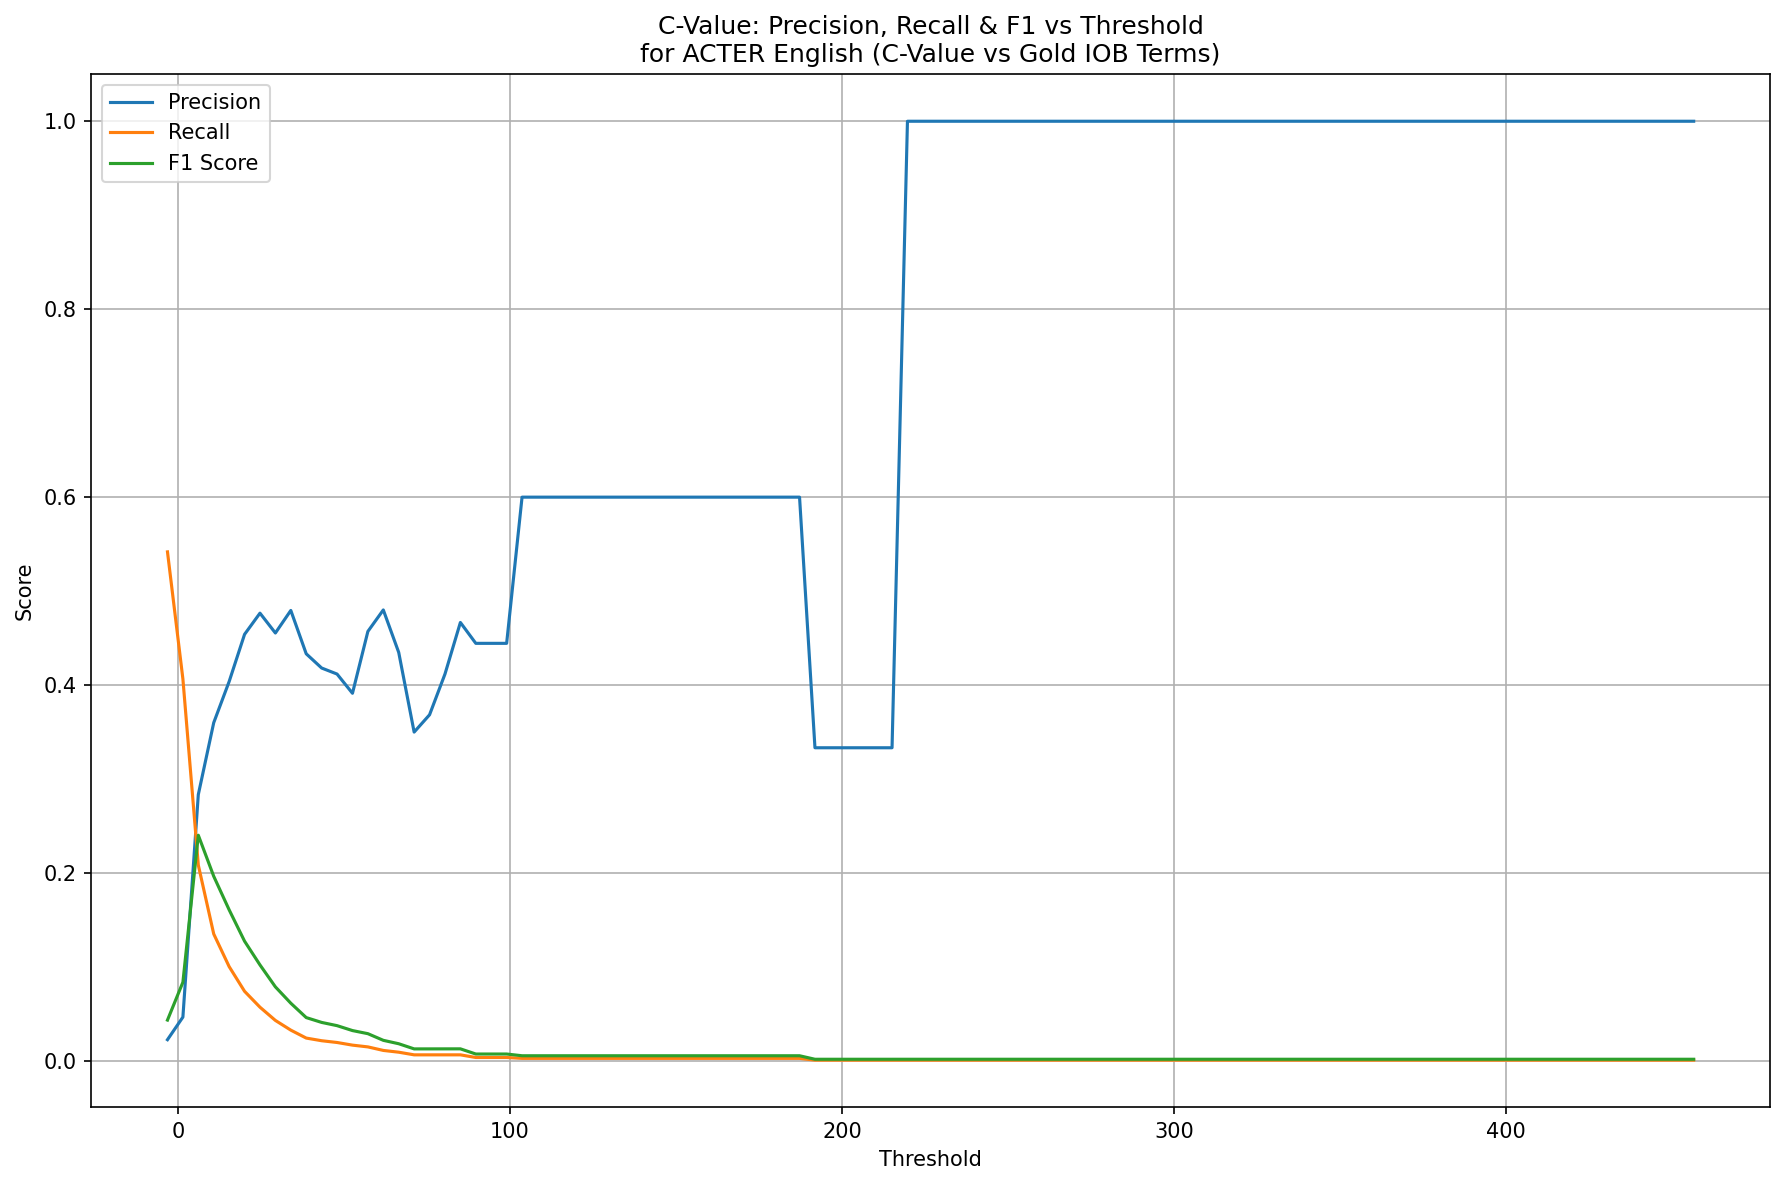

▶ Best C-Value results (threshold sweep):
   threshold = 6.15758
   precision = 0.284
   recall    = 0.208
   F1        = 0.240


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import importlib.util
from pathlib import Path

# ── dynamically load tester.py from extractomat ────────────────────────────
extractomat_dir = Path.cwd() / "extractomat"
tester_file = extractomat_dir / "tester.py"
spec = importlib.util.spec_from_file_location("tester", str(tester_file))
tester = importlib.util.module_from_spec(spec)
spec.loader.exec_module(tester)
TermEvaluator = tester.TermEvaluator

# ── evaluator setup ───────────────────────────────────────────────────────
evaluator = TermEvaluator(
    "acter_en_gt.csv",   # Gold-standard terms from IOB validation
    term_scores,         # your C-Value scores
    term_occ,            # your occurrence dict
    method="cvalue",
    language="en"
)

# ── threshold sweep ────────────────────────────────────────────────────────
scores = np.array(list(term_scores.values()))
t_min, t_max = scores.min(), scores.max()
thresholds = np.linspace(t_min - 1e-9, t_max, num=100)

precisions, recalls, f1_scores = [], [], []
for t in thresholds:
    try:
        p, r, f1 = evaluator.calculate_metrics(t)
    except ZeroDivisionError:
        p = r = f1 = 0.0
    precisions.append(p)
    recalls.append(r)
    f1_scores.append(f1)

# ── plotting ──────────────────────────────────────────────────────────────
plt.figure(figsize=(12, 8), dpi=150)
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls,    label="Recall")
plt.plot(thresholds, f1_scores,  label="F1 Score")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("C-Value: Precision, Recall & F1 vs Threshold\nfor ACTER English (C-Value vs Gold IOB Terms)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("▶ Best C-Value results (threshold sweep):")
print(f"   threshold = {best['threshold']:.5f}")
print(f"   precision = {best['precision']:.3f}")
print(f"   recall    = {best['recall']:.3f}")
print(f"   F1        = {best['f1']:.3f}")



In [ ]:
# # Cell 7 – serialize C-Value outputs (term_scores + term_occ as index tuples)
# import pickle
# from pathlib import Path

# # 1) Convert your term_occ from spaCy.Spans → list of (start, end) indices
# term_occ_tuples = {
#     term: [(span.start, span.end) for span in spans]
#     for term, spans in term_occ.items()
# }

# # 2) Dump both term_scores and the index‐tuple mapping
# OUT_PATH = Path("cvalue_results.pkl")
# with OUT_PATH.open("wb") as f:
#     pickle.dump({
#         "term_scores":     term_scores,
#         "term_occ_tuples": term_occ_tuples
#     }, f)

# print(f"✓ Saved serialised C-Value data → {OUT_PATH}")


In [ ]:
# !pip install -U pip setuptools wheel
# !pip install -U spacy
# !python -m spacy download en_core_web_sm

In [ ]:
# import pickle
# import spacy
# from pathlib import Path

# data = pickle.load(open("cvalue_results.pkl", "rb"))
# term_scores     = data["term_scores"]
# term_occ_tuples = data["term_occ_tuples"]
# print(f"🔄 Loaded {len(term_scores):,} C-Value candidates")

# # ── 2) Re-parse the unlabeled corpus (cheap on GPU!) ────
# nlp = spacy.load("en_core_web_sm", disable=["ner"])
# doc = nlp(Path("acter_en_unlabeled.txt").read_text().lower())

In [ ]:
import sys, os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# ── ensure extractomat is importable ───────────────────────────────────────
sys.path.insert(0, os.path.join(os.getcwd(), "extractomat"))
from sbert_reranker import SentenceSimilarityCalculator

# ── load torch & SBERT (GPU if available) ─────────────────────────────────
import torch
from sentence_transformers import SentenceTransformer  # imported for completeness

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🔧 SBERT device → {device}")

# ── instantiate the reranker correctly ────────────────────────────────────
reranker = SentenceSimilarityCalculator(
    model_name="sentence-transformers/paraphrase-multilingual-mpnet-base-v2",
    device=device
)

# ── re-rank your C-Value candidates ───────────────────────────────────────
reranked_scores = reranker.rerank_terms_in_doc(
    doc,             # spaCy Doc from C-Value step
    term_occ,        # occurrences dict from C-Value step
    context_len=3,
    pooling="max"
)
print(f"✅ Re-ranked {len(reranked_scores):,} terms")

# ── rebuild gold terms from IOB validation split (val_full.tsv) ──────────
val_tsv = Path("val_full.tsv")
gold_terms = set()
current = []

for line in val_tsv.read_text(encoding="utf-8").splitlines():
    if not line.strip():
        if current:
            gold_terms.add(" ".join(current).lower())
            current = []
        continue
    token, label = line.split("\t")
    if label.startswith("B"):
        if current:
            gold_terms.add(" ".join(current).lower())
        current = [token]
    elif label.startswith("I") and current:
        current.append(token)
    else:
        if current:
            gold_terms.add(" ".join(current).lower())
            current = []
if current:
    gold_terms.add(" ".join(current).lower())

print(f"🎯 Loaded {len(gold_terms):,} gold terms")

🔧 SBERT device → cuda


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-19-f408d20b3d68>", line 24, in <cell line: 0>
    reranked_scores = reranker.rerank_terms_in_doc(
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/extractomat/sbert_reranker.py", line 142, in rerank_terms_in_doc
    context_sentences = extract_context(doc, term_occurences, context_len)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/extractomat/matcha.py", line None, in extract_context
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
          ^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'Keyboa

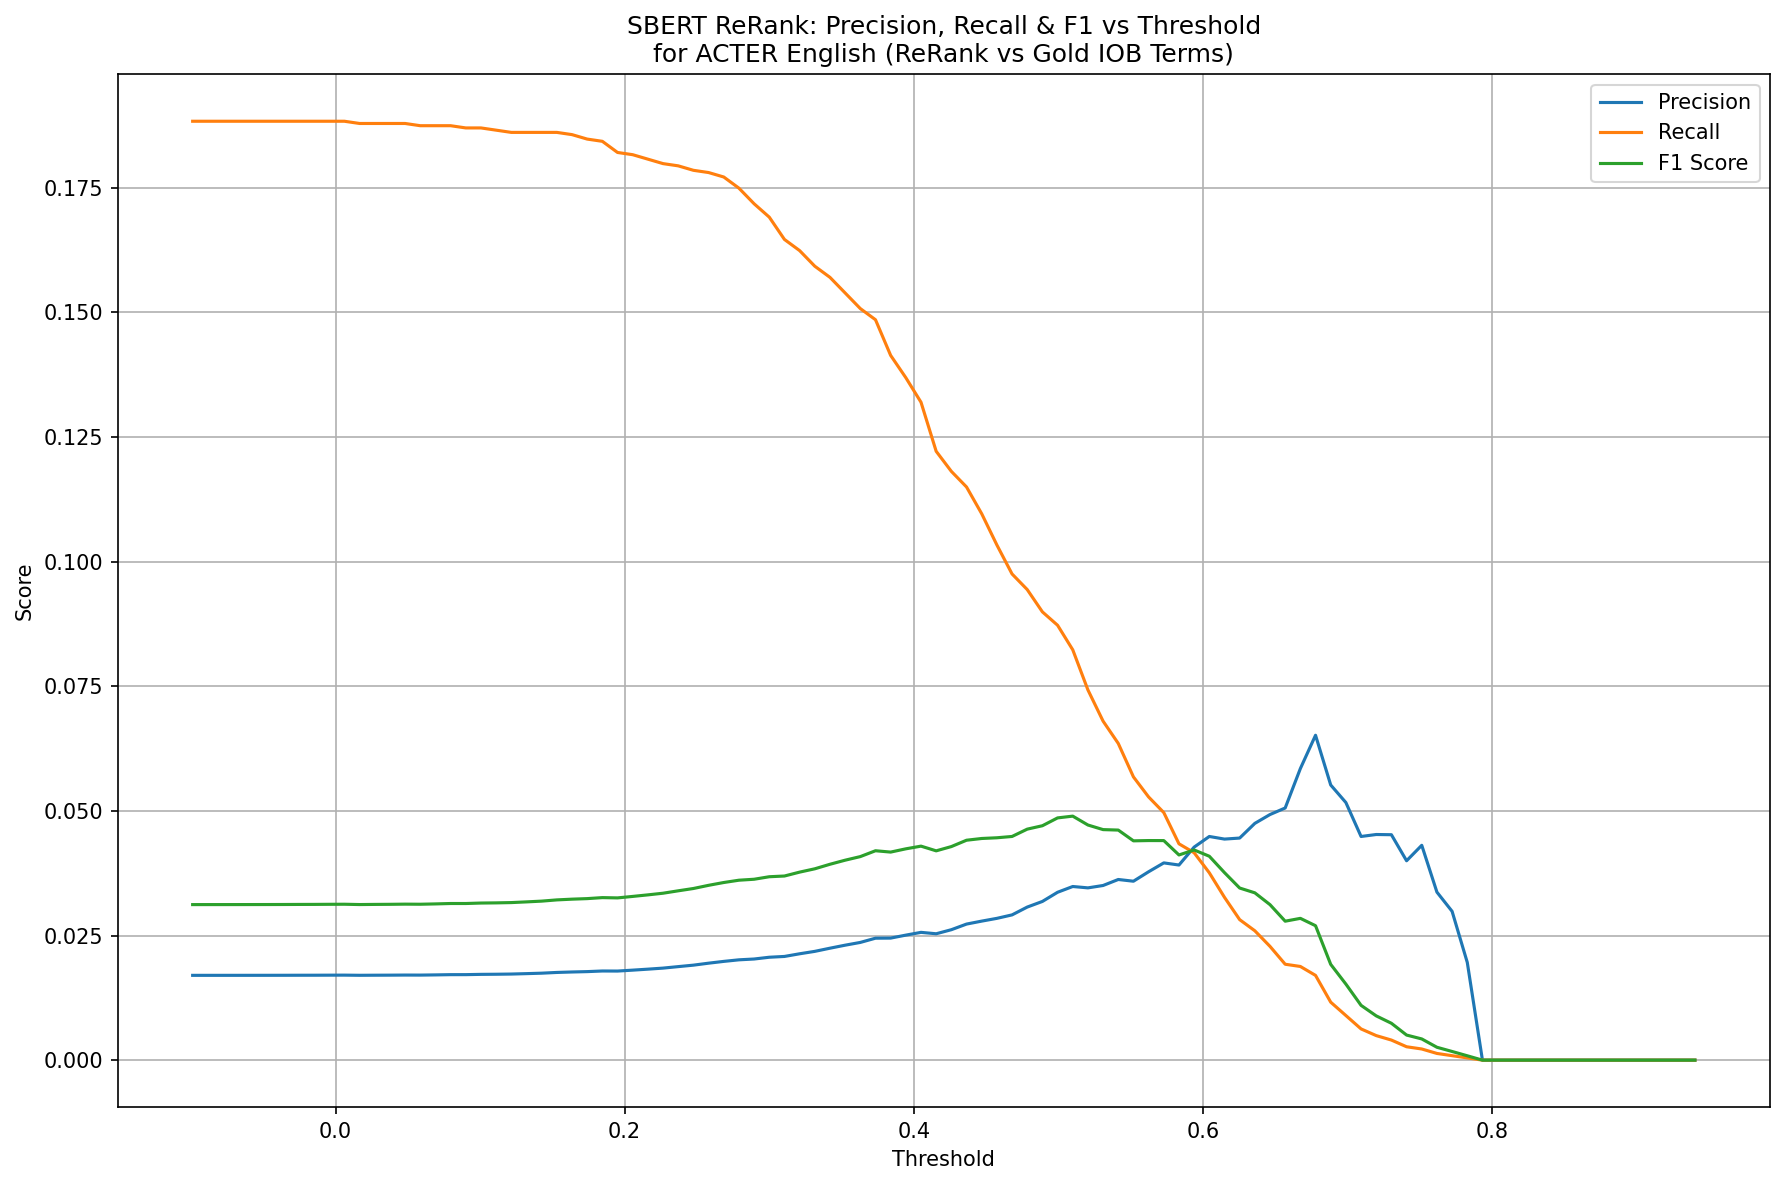

▶ Best ReRanked Results:
   threshold = 0.51002
   precision = 0.035
   recall    = 0.082
   F1        = 0.049


In [ ]:
scores = np.array(list(reranked_scores.values()))
t_min, t_max = scores.min(), scores.max()
thresholds = np.linspace(t_min - 1e-9, t_max, num=100)

precisions, recalls, f1_scores = [], [], []
for t in thresholds:
    preds = {term for term, sc in reranked_scores.items() if sc >= t}
    tp = len(preds & gold_terms)
    p = tp / len(preds) if preds else 0.0
    r = tp / len(gold_terms) if gold_terms else 0.0
    f1 = (2 * p * r / (p + r)) if (p + r) > 0 else 0.0
    precisions.append(p)
    recalls.append(r)
    f1_scores.append(f1)

# ── plot Precision, Recall & F1 vs Threshold ─────────────────────────────
plt.figure(figsize=(12, 8), dpi=150)
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls,    label="Recall")
plt.plot(thresholds, f1_scores,  label="F1 Score")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title(
    "SBERT ReRank: Precision, Recall & F1 vs Threshold\n"
    "for ACTER English (ReRank vs Gold IOB Terms)"
)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
scores_arr = np.array(list(reranked_scores.values()))
t_min, t_max = scores_arr.min(), scores_arr.max()
thresholds = np.linspace(t_min - 1e-9, t_max, num=100)

best = {"f1": -1.0}
for t in thresholds:
    preds = {term for term, sc in reranked_scores.items() if sc >= t}
    tp = len(preds & gold_terms)
    p = tp / len(preds) if preds else 0.0
    r = tp / len(gold_terms) if gold_terms else 0.0
    f1 = (2 * p * r / (p + r)) if (p + r) > 0 else 0.0
    if f1 > best["f1"]:
        best.update(threshold=t, precision=p, recall=r, f1=f1)

print("▶ Best ReRanked Results:")
print(f"   threshold = {best['threshold']:.5f}")
print(f"   precision = {best['precision']:.3f}")
print(f"   recall    = {best['recall']:.3f}")
print(f"   F1        = {best['f1']:.3f}")

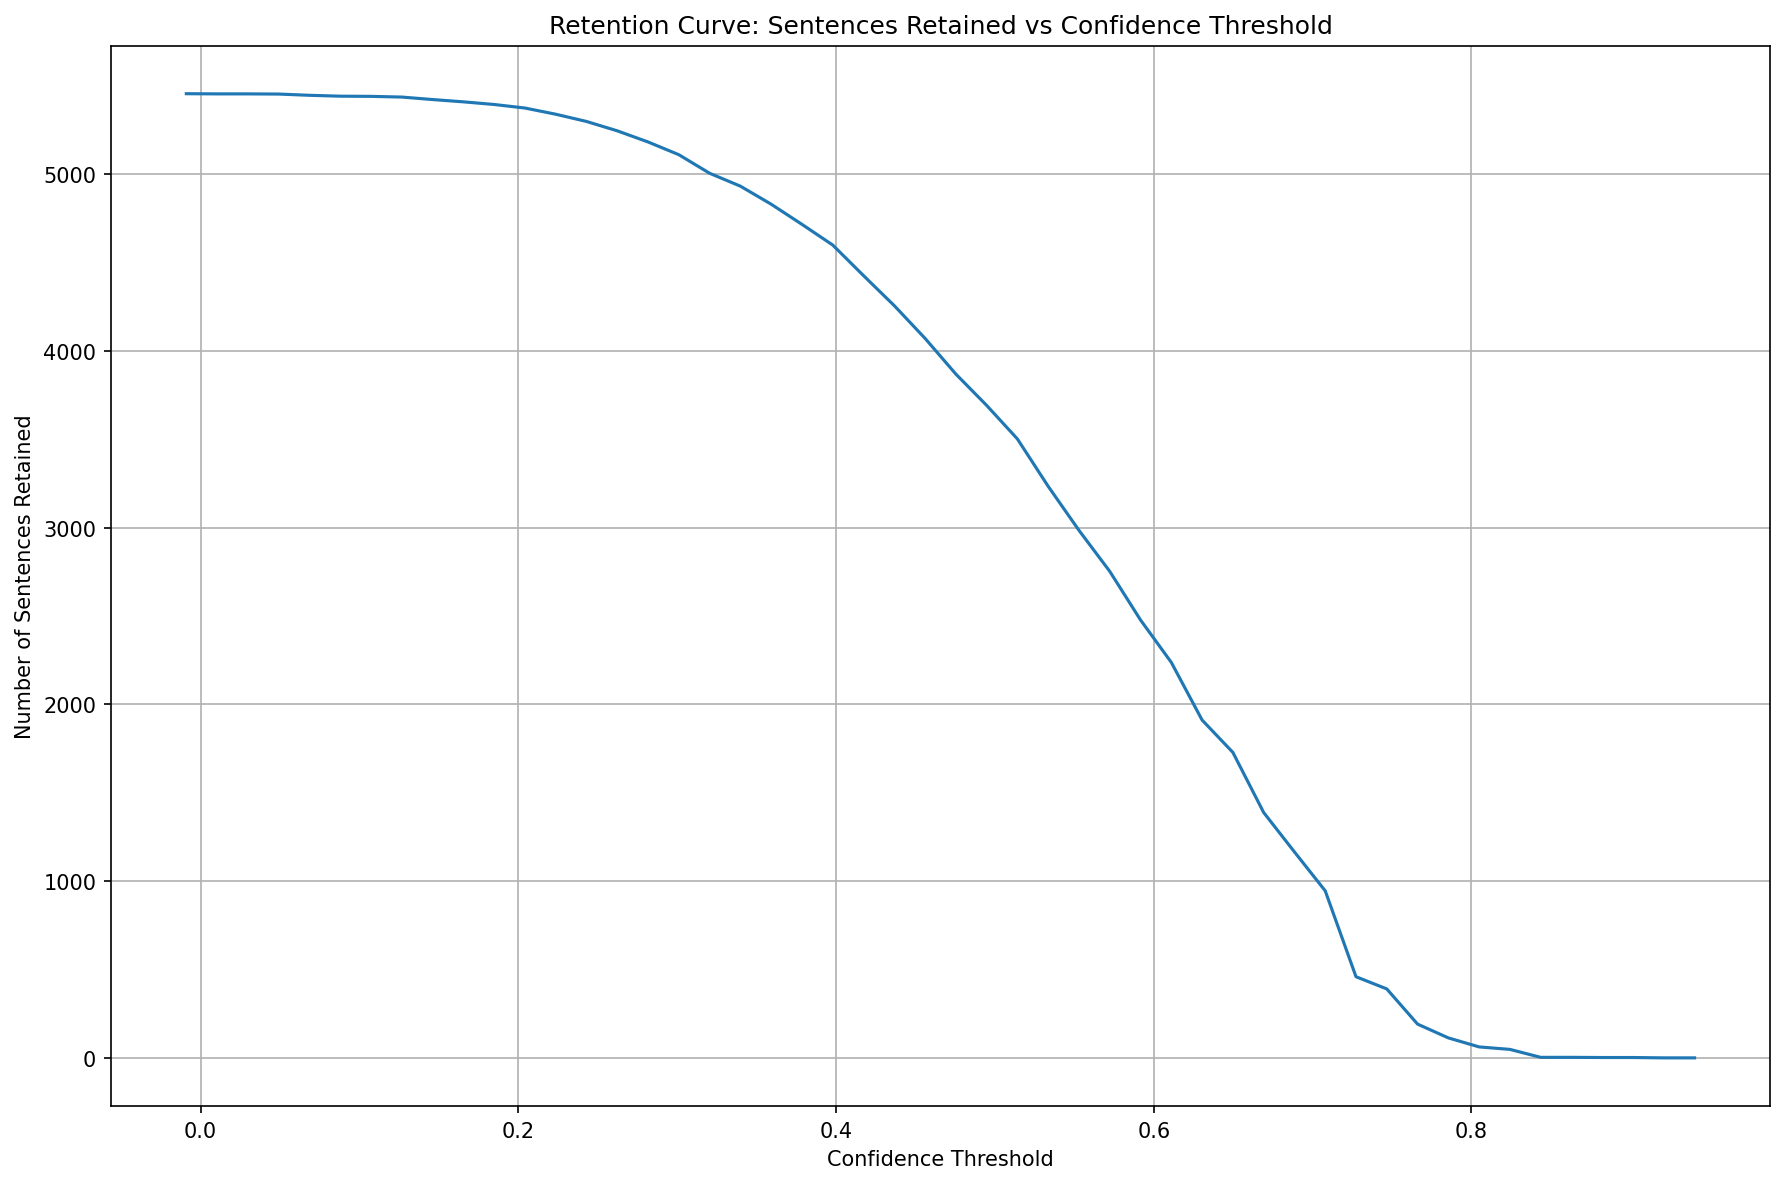

Sample sentences with confidence ≥ 0.575:
 - a total of 3.5 billion euros have been allocated under those guidelines to strengthen institutional capacity at national , regional and local level of which 2 billion euros stem from the european social fund .

 - the commission intends to continue support for the strengthening of institutional capacity and make it available to all member states and regions .

 - the proposal / initiative relates to the extension of an existing action
the eu 's cohesion policy supports the strengthening of institutional capacity in member states to make public services and administrations more efficient .

 - 20
main article : airs above the ground
.
such support for institutional capacity will have a positive impact on preventing corruption , by making public services and administrations more efficient and transparent .
in blade design of hawt the effect of parameters such as effect of reynolds number , effects of number of blades etc. are discussed and som

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Cell 7 – Compute per-sentence confidence and plot retention vs threshold

# Choose scores: prefer reranked_scores if available, else fallback to term_scores
scores_dict = globals().get('reranked_scores') or globals().get('term_scores')
occ_dict = globals().get('term_occ')

# Sanity check
assert scores_dict is not None and occ_dict is not None, \
    "Error: term_scores/term_occ or reranked_scores/term_occ not found in memory."

# Map each sentence to the list of term scores within it
sent_scores = defaultdict(list)
for term, spans in occ_dict.items():
    score = scores_dict[term]
    for span in spans:
        sent = span.sent  # spaCy Span.sent property gives the sentence
        sent_scores[sent].append(score)

# Compute confidence per sentence as the max score of its term predictions
sent_conf = {sent: max(scores) for sent, scores in sent_scores.items()}

# Prepare retention data for threshold sweep
conf_values = np.array(list(sent_conf.values()))
t_min, t_max = conf_values.min(), conf_values.max()
thresholds = np.linspace(t_min - 1e-9, t_max, num=50)
retentions = [sum(1 for c in conf_values if c >= t) for t in thresholds]

# Plot retention curve
plt.figure(figsize=(12, 8), dpi=150)
plt.plot(thresholds, retentions)
plt.xlabel("Confidence Threshold")
plt.ylabel("Number of Sentences Retained")
plt.title("Retention Curve: Sentences Retained vs Confidence Threshold")
plt.grid(True)
plt.tight_layout()
plt.show()

# Display a few example sentences above the median confidence
median_conf = np.median(conf_values)
kept = [sent for sent, c in sent_conf.items() if c >= median_conf]
print(f"Sample sentences with confidence ≥ {median_conf:.3f}:")
for sent in kept[:5]:
    print(" -", sent.text)


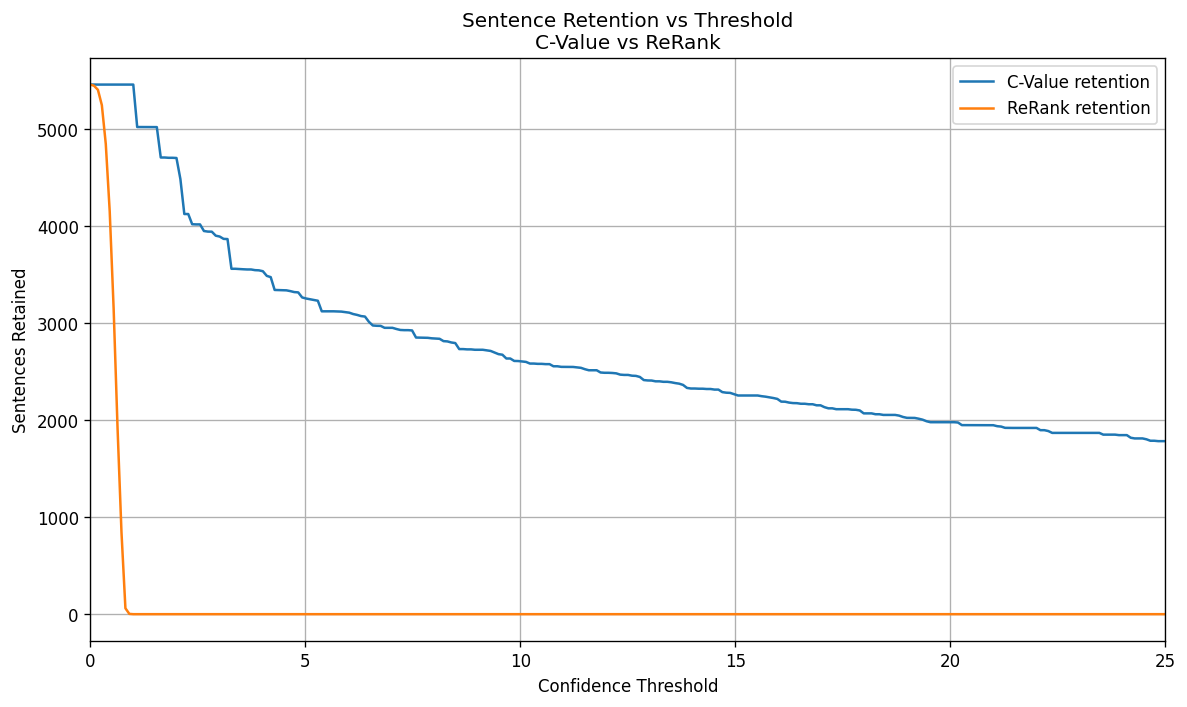

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Build thresholds over the union of both domains
all_confs = np.concatenate([list(sent_conf_c.values()), list(sent_conf_r.values())])
t_min, t_max = all_confs.min(), all_confs.max()
thresholds = np.linspace(t_min, t_max, num=5000)

ret_c = [(np.sum(list(sent_conf_c.values()) >= t)) for t in thresholds]
ret_r = [(np.sum(list(sent_conf_r.values()) >= t)) for t in thresholds]


plt.figure(figsize=(10, 6), dpi=120)
plt.xlim(0, 25)
plt.plot(thresholds, ret_c, label="C-Value retention")
plt.plot(thresholds, ret_r, label="ReRank retention")
plt.xlabel("Confidence Threshold")
plt.ylabel("Sentences Retained")
plt.title("Sentence Retention vs Threshold\nC-Value vs ReRank")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


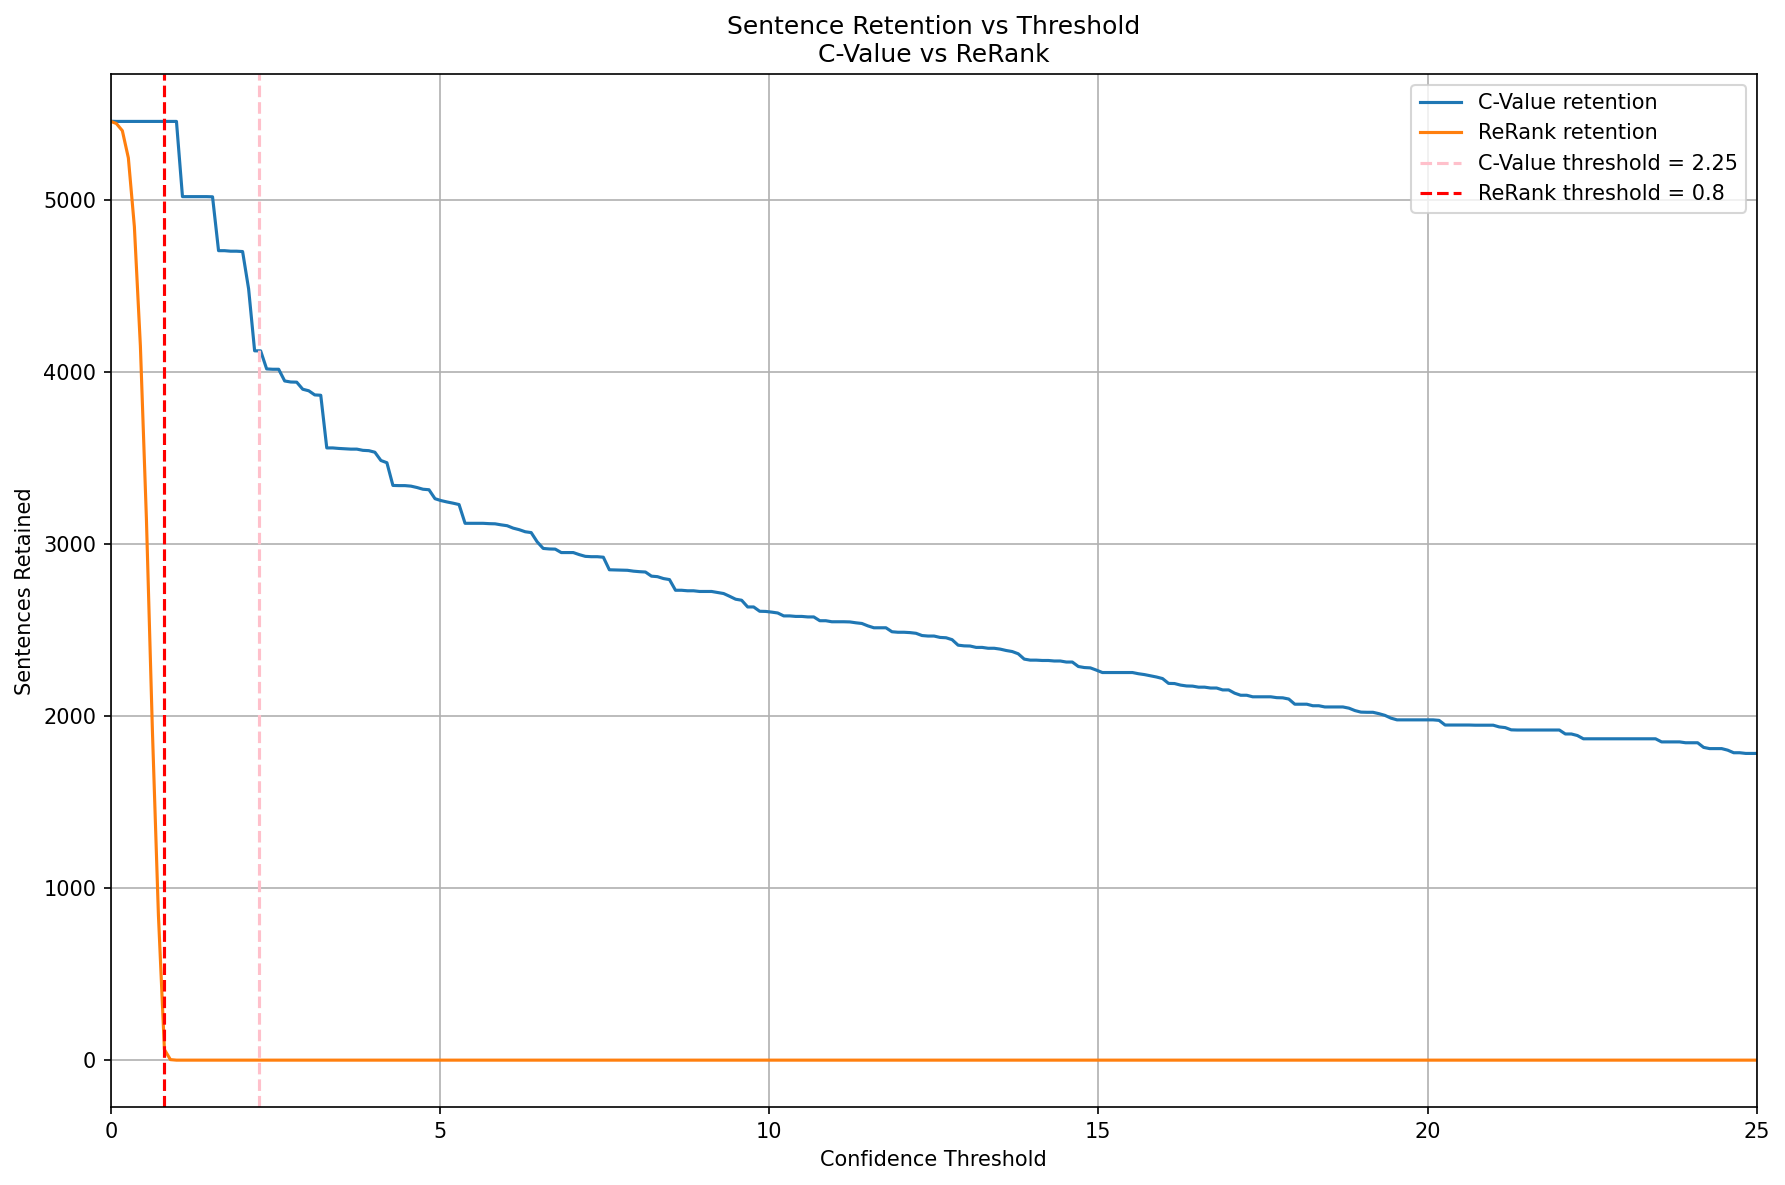

C-Value threshold 2.25: retained 4121/6938 sentences (59.40%)
ReRank threshold 0.8: retained 90/6938 sentences (1.30%)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assumes sent_conf_c, sent_conf_r, and doc are already in memory
assert 'sent_conf_c' in globals() and 'sent_conf_r' in globals(), "Run the confidence computation cell first"
assert 'doc' in globals(), "Run the C-Value extraction cell to define `doc`"

# Fixed thresholds for each method
threshold_c = 2.25  # C-Value cutoff
threshold_r = 0.45  # ReRank cutoff

# Build fine-grained thresholds over observed confidence ranges
all_confs = np.concatenate([list(sent_conf_c.values()), list(sent_conf_r.values())])
t_min, t_max = all_confs.min(), all_confs.max()
thresholds = np.linspace(t_min, t_max, num=5000)

# Compute retention counts at each threshold
ret_c = np.array([np.sum(np.array(list(sent_conf_c.values())) >= t) for t in thresholds])
ret_r = np.array([np.sum(np.array(list(sent_conf_r.values())) >= t) for t in thresholds])

# Plot retention curves
plt.figure(figsize=(12, 8), dpi=150)
plt.plot(thresholds, ret_c, label="C-Value retention")
plt.plot(thresholds, ret_r, label="ReRank retention")

# Limit x-axis and add vertical threshold lines
plt.xlim(0, 25)
plt.axvline(threshold_c, color='pink', linestyle='--', label=f"C-Value threshold = {threshold_c}")
plt.axvline(threshold_r, color='red', linestyle='--', label=f"ReRank threshold = {threshold_r}")

plt.xlabel("Confidence Threshold")
plt.ylabel("Sentences Retained")
plt.title("Sentence Retention vs Threshold\nC-Value vs ReRank")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Calculate and print percentages of sentences retained
total_sents = len(list(doc.sents))
retained_c = np.sum(np.array(list(sent_conf_c.values())) >= threshold_c)
retained_r = np.sum(np.array(list(sent_conf_r.values())) >= threshold_r)
pct_c = retained_c / total_sents * 100
pct_r = retained_r / total_sents * 100

print(f"C-Value threshold {threshold_c}: retained {retained_c}/{total_sents} sentences ({pct_c:.2f}%)")
print(f"ReRank threshold {threshold_r}: retained {retained_r}/{total_sents} sentences ({pct_r:.2f}%)")


In [ ]:
from pathlib import Path
from collections import defaultdict
from tqdm.auto import tqdm
import sys, os

# ── ensure extractomat is importable ───────────────────────────────────────
sys.path.insert(0, os.path.join(os.getcwd(), "extractomat"))

# ── preconditions ─────────────────────────────────────────────────────────
assert 'doc' in globals(), "Please re-run C-Value extraction to define `doc`."
assert 'term_occ' in globals(), "Please re-run C-Value extraction to define `term_occ`."
assert 'term_scores' in globals(), "Please re-run C-Value extraction to define `term_scores`."
assert 'reranked_scores' in globals(), "Please re-run SBERT ReRank to define `reranked_scores`."

# ── map sentences to their spans with scores ──────────────────────────────
sent2spans = defaultdict(list)
for term, spans in term_occ.items():
    sc = term_scores[term]
    sr = reranked_scores[term]
    for span in spans:
        # find parent sentence by boundaries
        for sent in doc.sents:
            if span.start >= sent.start and span.end <= sent.end:
                sent2spans[sent].append((span, sc, sr))
                break

# ── prepare sentences ───────────────────────────────────────────────────────
sentences = list(doc.sents)

# ── define splits and their inclusion functions ────────────────────────────
splits = {
    # "train_cvalue_original.tsv":       lambda spans: True,
    # f"train_cvalue_conf{threshold_c}.tsv": lambda spans: max((sc for _, sc, _ in spans), default=0) >= threshold_c,
    # "train_rerank_original.tsv":       lambda spans: True,
    f"train_rerank_conf{threshold_r}.tsv": lambda spans: max((sr for _, _, sr in spans), default=0) >= threshold_r,
}

# ── output directory ───────────────────────────────────────────────────────
output_dir = Path("/content/drive/MyDrive/ucu/ner/datasets")
output_dir.mkdir(exist_ok=True)


# ── generate each file with stats logging ─────────────────────────────────
for fname, keep_fn in splits.items():
    out_path = output_dir / fname
    b_count = i_count = o_count = blank_count = 0
    with out_path.open("w", encoding="utf-8") as fout:
        for sent in tqdm(sentences, desc=f"Writing {fname}", unit="sent"):
            spans = sent2spans.get(sent, [])
            if not keep_fn(spans):
                continue

            # initialize labels
            labels = ["O"] * len(sent)
            # assign B/I labels for spans above threshold
            for span, sc, sr in spans:
                score = sc if "cvalue" in fname else sr
                thresh = threshold_c if "cvalue" in fname else threshold_r
                if score < thresh:
                    continue
                start = span.start - sent.start
                end   = span.end   - sent.start
                labels[start] = "B"
                for j in range(start+1, end):
                    labels[j] = "I"

            # write tokens and count labels
            for token, lbl in zip(sent, labels):
                if lbl == "O":
                    o_count += 1
                    fout.write(f"{token.text}\tO\n")
                else:
                    if lbl == "B":
                        b_count += 1
                        fout.write(f"{token.text}\tB-TERM\n")
                    else:
                        i_count += 1
                        fout.write(f"{token.text}\tI-TERM\n")
            # end of sentence
            fout.write("\n")
            blank_count += 1

    print(f"✓ Wrote {out_path.name}")
    print(f"  → Sentences (blanks): {blank_count}")
    print(f"  → B-TERM tokens:     {b_count}")
    print(f"  → I-TERM tokens:     {i_count}")
    print(f"  → O tokens:          {o_count}\n")


Writing train_cvalue_original.tsv:   0%|          | 0/6938 [00:00<?, ?sent/s]

✓ Wrote train_cvalue_original.tsv
  → Sentences (blanks): 6938
  → B-TERM tokens:     9031
  → I-TERM tokens:     20528
  → O tokens:          165372



Writing train_cvalue_conf2.25.tsv:   0%|          | 0/6938 [00:00<?, ?sent/s]

✓ Wrote train_cvalue_conf2.25.tsv
  → Sentences (blanks): 4120
  → B-TERM tokens:     9031
  → I-TERM tokens:     20528
  → O tokens:          117720



Writing train_rerank_original.tsv:   0%|          | 0/6938 [00:00<?, ?sent/s]

✓ Wrote train_rerank_original.tsv
  → Sentences (blanks): 6938
  → B-TERM tokens:     101
  → I-TERM tokens:     394
  → O tokens:          194436



Writing train_rerank_conf0.8.tsv:   0%|          | 0/6938 [00:00<?, ?sent/s]

✓ Wrote train_rerank_conf0.8.tsv
  → Sentences (blanks): 90
  → B-TERM tokens:     101
  → I-TERM tokens:     394
  → O tokens:          3294

